In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import csv
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa import stattools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import os
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
# import tensorflow as tf
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# sess = tf.Session(config=config)

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, RNN, GRU, SimpleRNN, Dropout
from math import sqrt
from matplotlib import pyplot
from numpy import array
from sklearn.preprocessing import MinMaxScaler
os.environ['CUDA_VISIBLE_DEVICES']=''
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

<ipython-input-1-2de374cffe5c>:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


ImportError: cannot import name 'set_random_seed' from 'tensorflow' (C:\Users\ayush\anaconda3\lib\site-packages\tensorflow\__init__.py)

In [3]:
data = pd.read_csv('monthdata.csv', header=None, names=['datetime', 'load'], index_col=[0], parse_dates=[0], infer_datetime_format=True)
df = pd.DataFrame(columns=['time'] + list(map(str, range(int(data.shape[0] / 288)))))
for idx, time in enumerate(sorted(set(data.index.time))):
    df.loc[idx] = [time.strftime(format='%H:%M:%S')] + list(data.at_time(time)['load'].values)
df.index = df['time']
df = df.drop('time', 1)
dt_df = df.diff(1, axis=1)
dt_df = dt_df.dropna(axis=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(dt_df.values.reshape(-1, 1))
dt_df = scaler.transform(dt_df)  # dt_df is now a numpy array
split_idx = int(len(dt_df) * 0.8)
train, val = dt_df[:split_idx, :], dt_df[split_idx:, :]

In [4]:
def prepare_data(data, nlags):
    '''prepares data for LSTM model, x=last nlags values, y=(nlags+1)'th value'''
    data_x, data_y = [], []
    for i in range(data.shape[0]):
        for j in range(0, data.shape[1]-nlags):
            data_x.append(data[i, j:j+nlags])
            data_y.append(data[i, j+nlags])
    data_x = np.array(data_x)
    data_y = np.array(data_y).reshape(-1, 1)
    return data_x, data_y

In [17]:
## get today's load

def get_load_data(date):
    load=[]
    url = 'http://www.delhisldc.org/Loaddata.aspx?mode='
    print('Scraping ' + date, end=' ')
    resp = requests.get(url + date) # send a get request to the url, get response
    soup = BeautifulSoup(resp.text, 'lxml') # Yummy HTML soup
    table = soup.find('table', {'id':'ContentPlaceHolder3_DGGridAv'}) # get the table from html
    trs = table.findAll('tr') # extract all rows of the table
    if len(trs[1:])==288: # no need to create csv file, if there's no data
         with open('monthdata.csv', 'a') as f:  #'a' makes sure the values are appended at the end of the already existing file
           
             for tr in trs[1:]:
                time, delhi = tr.findChildren('font')[:2]
                load.append(delhi.text)
    if len(trs[1:]) != 288:
         print('Some of the load values are missing..')
    else:
         print('Done')
    return load
yesterday = datetime.today() - timedelta(1)
yesterday = yesterday.strftime('%d/%m/%Y')
load = get_load_data(yesterday)
load = [float(x) for x in load]
np.save('25nov.npy', load)

Scraping 20/05/2021 Done


In [18]:
nlags = 10
train_x, train_y = prepare_data(train, nlags)
val_x, val_y = prepare_data(val, nlags)
train_x = train_x.reshape(train_x.shape[0], 1, nlags)
val_x = val_x.reshape(val_x.shape[0], 1, nlags)
df_last_nlags_plus_one = df.loc[:, df.columns[-nlags-1:]]  # slice last nlags+1 days from df, will be used in prediction of yesterday's data
dt_df_last_nlags = df_last_nlags_plus_one.diff(1, axis=1).dropna(axis=1)  #taking last 21 days, differencing and dropping the nan value
dt_df_last_nlags = scaler.transform(dt_df_last_nlags)  # df is now a numpy array
X = dt_df_last_nlags.reshape(dt_df_last_nlags.shape[0], 1, nlags)  # nlags=20
load = np.load('25nov.npy')

#### Training

In [19]:
batch_size = 1
model = Sequential()
model.add(SimpleRNN(1, batch_input_shape=(batch_size, train_x.shape[1], train_x.shape[2])))
model.add(Dense(train_y.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')
es = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=0, mode='auto')

In [20]:
history = model.fit(train_x, train_y, epochs=20, batch_size=batch_size, verbose=1, validation_data=(val_x, val_y), shuffle=True, callbacks=[es])


Epoch 1/20
4370/4370 [==============================] - 6s 1ms/step - loss: 0.0390 - val_loss: 0.0330
Epoch 2/20
4370/4370 [==============================] - 5s 1ms/step - loss: 0.0204 - val_loss: 0.0275
Epoch 3/20
4370/4370 [==============================] - 5s 1ms/step - loss: 0.0166 - val_loss: 0.0257
Epoch 4/20
4370/4370 [==============================] - 6s 1ms/step - loss: 0.0152 - val_loss: 0.0252
Epoch 5/20
4370/4370 [==============================] - 8s 2ms/step - loss: 0.0174 - val_loss: 0.0252
Epoch 6/20
4370/4370 [==============================] - 8s 2ms/step - loss: 0.0163 - val_loss: 0.0257
Epoch 7/20
4370/4370 [==============================] - 8s 2ms/step - loss: 0.0160 - val_loss: 0.0263


In [21]:
# fit network
early_stopping_counter = 0
last_loss = np.inf
for i in range(20):
    history = model.fit(train_x, train_y, epochs=1, batch_size=batch_size, verbose=1, validation_data=(val_x, val_y), shuffle=False)
    model.reset_states()
    val_loss = history.history['val_loss'][0]
    if val_loss > last_loss:
        early_stopping_counter += 1
    else:    
        early_stopping_counter = 0
    last_loss = val_loss
    if early_stopping_counter == 3:
#         break
        pass

4370/4370 [==============================] - 8s 2ms/step - loss: 0.0145 - val_loss: 0.0260


#### Prediction

In [22]:
val_y_pred = model.predict(val_x, batch_size=batch_size, verbose=1)
inverted_val_y = scaler.inverse_transform(val_y)
inverted_val_y_pred = scaler.inverse_transform(val_y_pred)
Y = model.predict(X, batch_size=batch_size)  # predict for today's values
inv_Y = scaler.inverse_transform(Y)  # invert to detrended values' scale
rescaled_Y = [x+y for x, y in zip(inv_Y[:, 0], df.iloc[:, -1])]  # last day's values added to inv_Y to get it to original scale


1102/1102 [==============================] - 12s 1ms/step


In [23]:
val_RMSE = np.sqrt(np.sum(np.square(np.array(inverted_val_y_pred) - np.array(inverted_val_y))) / len(inverted_val_y)) 
RMSE = np.sqrt(np.sum(np.square(np.array(rescaled_Y) - load)) / len(load)) 
print(val_RMSE, RMSE)

225.90453582898078 907.7427770603673


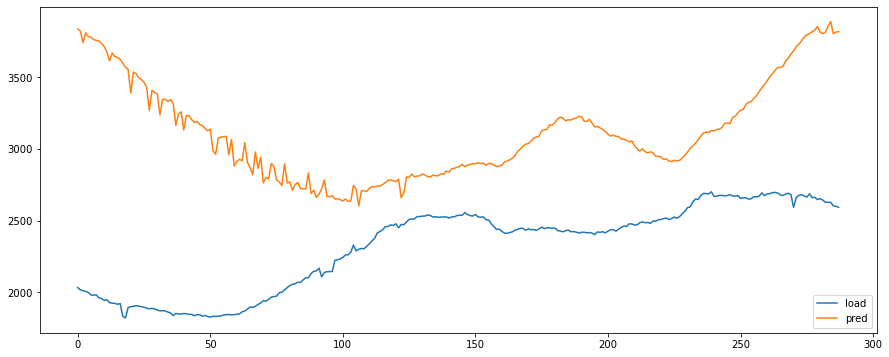

In [24]:
plt.plot(load)
plt.plot(rescaled_Y)
plt.legend(['load', 'pred'])